In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import random 
import datetime as dt
import re 
import pickle 
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from string import digits, punctuation
from scipy.stats import chi2_contingency 
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score 
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline
import os

In [2]:
data = pd.read_csv(r'C:\Users\Mallikarjun\Desktop\Data Science\Projects\EcommerceCustomerSegmentation\data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


 Cleaning the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Check missing values for each column¶


In [4]:
data.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

Text(0.5, 1.0, 'Ratio of missing values per columns')

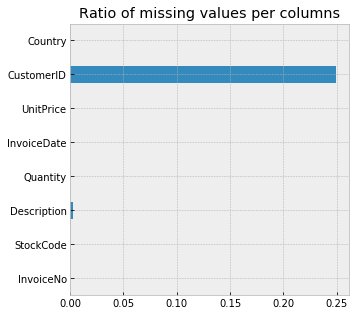

In [5]:
# Let's take a look at the missing values
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

Let's go deeper in these missing values

In [6]:
nan_rows = data[data.isnull().T.any().T]
nan_rows.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


Since the missing values are only in the CustomerID column and the description column, we could try to look at the InvoiceNo and see if maybe we can find the Customer ID

In [7]:
data[data['InvoiceNo']== '536414']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom


In [8]:
data[data['InvoiceNo']== '536544'][:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom


It appears that we can't replace the missing values and we can't keep data without the value in the customer id columns since we want to classify the customers. So I'll drop the lines with missing values on the customer ID column.

In [9]:
data = data.dropna(subset=["CustomerID"])

In [10]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Text(0.5, 1.0, 'Ratio of missing values per columns')

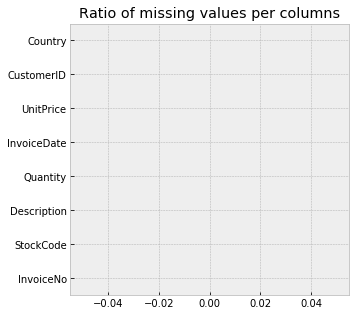

In [11]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

There are no more missing values. I'll now check the dupplicate values and drop them if there's any.

In [12]:
print('Dupplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Dupplicate entries: 5225


In [13]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Exploratory Analysis: Countries

In [14]:
data.Country.nunique()

37

In [15]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


In [16]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


More than 90% of the data is coming from UK !

Exploratory Analysis: Quantity

In [17]:
data.describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [18]:
data[(data['Quantity']<0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


This is very interesting since we can see various things here :

The stock code values aren't only numerical, there are speciales values like D which means Discount
The InvoiceNo aren't also only numerical since there is a C before the other numbers for every negative value in the quantity column, this could mean that the order was canceled.
I'll analyse the InvoiceNo to find any patterns.

In [19]:
# Constucting a basket for later use
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [20]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

It appears that more than 16% of the transactions were canceled which is significant. Let's take a look at some rows where the transaction was canceled.

In [21]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1][:5]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [22]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom


By looking at these results, it appears that there is a counterpart to the canceled transaction in the database. Let's see if this is always the case.

In [23]:
test = data[data['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Our initial hypothesis is wrong')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Our initial hypothesis is wrong


In [24]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,12/5/2010 13:17,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/5/2010 13:17,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,12/5/2010 13:17,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,12/5/2010 13:17,3.95,14527,United Kingdom


It appears that when there is a discount there are no counterparts. Let's try again but without the discount values

In [25]:
data[(data['CustomerID'] == '15311') & (data['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/5/2010 13:55,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/8/2010 13:18,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/13/2010 15:07,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,12/20/2010 15:27,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/5/2011 11:41,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/17/2011 13:39,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2/1/2011 12:14,4.65,15311,United Kingdom


It seels that the customer can also cancel just a part of the transaction which is logical so we need to take this into account for later.

In [29]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': 
        continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

In [32]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom,0
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom,0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom,0


In [33]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 6151
doubtfull_entry: 2607


In [34]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0


In [35]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

In [36]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom,0
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom,0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom,0


In [37]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

These are specific operations which doesn't characterize our customers so I'll just drop these transactions from our database

In [38]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

In [39]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom,0
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom,0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom,0


Outliers

In [40]:
df_cleaned.describe()

,Quantity,UnitPrice,QuantityCanceled
count,391183.000000,391183.000000,391183.000000
mean,13.179665,2.874130,0.583911
std,181.907403,4.284639,175.868790
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,80995.000000,649.500000,80995.000000


The minimum value for the unitprice is 0, let's see why is that.

In [42]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081,United Kingdom,0


I am tempted to replace the null values by the most common one but it might be a special discount or something else so I'll leave it like that. Here let's remove the items that got completely canceled in order to harmonize the futur clusters and not have too much special values.

 Feature engineering

In [43]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

InvoiceNo :  18405
StockCode :  3659
Description :  3871
Quantity :  300
InvoiceDate :  17169
UnitPrice :  356
CustomerID :  4335
Country :  37
QuantityCanceled :  115


Total Price

In [45]:
# Total price feature

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,0,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom,0,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom,0,25.50
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom,0,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom,0,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom,0,54.08


We can now look at the countries' monetary value thanks to this feature

Text(0.5, 1.0, 'Revenue per Country')

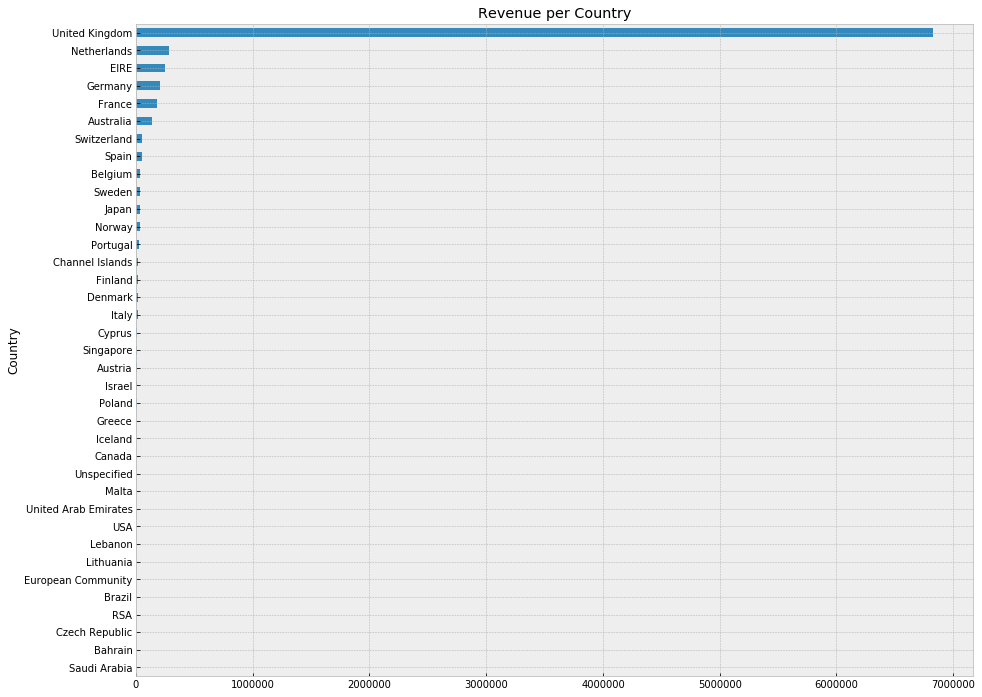

In [50]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")

Text(0.5, 1.0, 'Number of Invoices per Country')

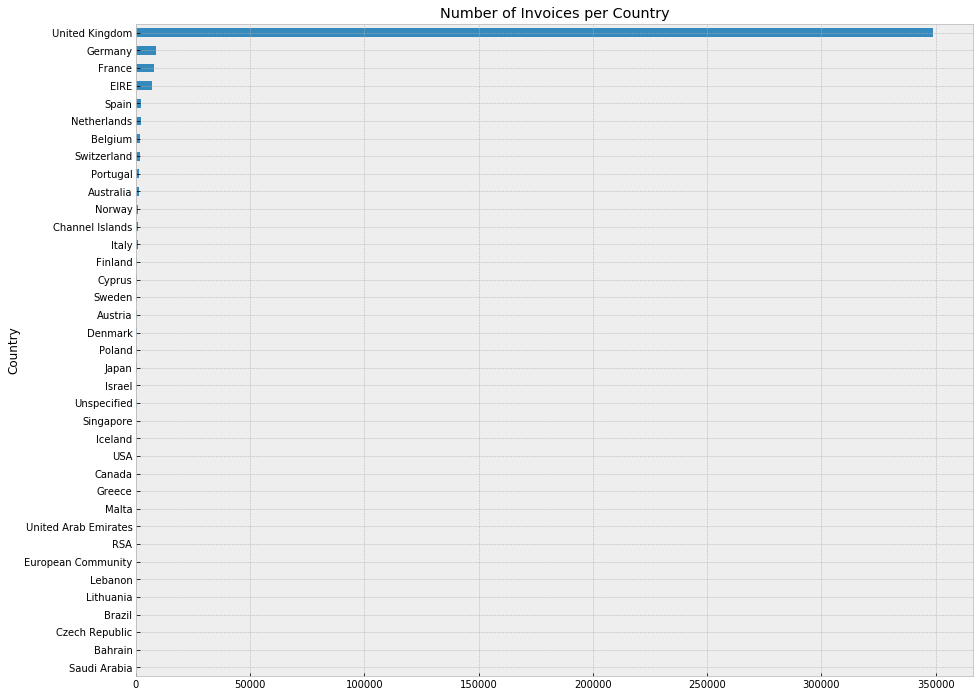

In [51]:
No_invoice_per_country = df_cleaned.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")

This is very interesting since we can see that Netherlands is the 2nd country in value even though it has less invoices than countries like Germany or France for example and 10 times less customers. (95, 87 and 9 for Germany, France and Netherlands respectively)

In [56]:
le = LabelEncoder()
le.fit(df_cleaned['Country'])

LabelEncoder()

In [57]:
l = [i for i in range(37)]
dict(zip(list(le.classes_), l))

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36}

In [58]:
df_cleaned['Country'] = le.transform(df_cleaned['Country'])

In [59]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,35,0,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,35,0,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,35,0,25.50
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,35,0,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,35,0,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,35,0,54.08


In [60]:
with open('labelencoder.pickle', 'wb') as g:
    pickle.dump(le, g)

In [61]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,35,0,20.34


I'll implement here the RFM principle to classify the customers in this database.RFM stands for Recency, Frequency and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

In [62]:
df_cleaned['InvoiceDate'].min()

'1/10/2011 10:32'

In [63]:
df_cleaned['InvoiceDate'].max()

'9/9/2011 9:52'

In [64]:
# I'll just fix the date to be one day after the last entry in the databse

NOW = dt.datetime(2011,12,10)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [65]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,35,0,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,35,0,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,35,0,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,35,0,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,35,0,54.08


In [69]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"


rfmTable = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [71]:
rfmTable.head()

,InvoiceDate,CustomerID,TotalPrice
InvoiceNo,,,
536365,2010-12-01 08:26:00,17850,139.12
536366,2010-12-01 08:28:00,17850,22.20
536367,2010-12-01 08:34:00,13047,278.73
536368,2010-12-01 08:34:00,13047,70.05
536369,2010-12-01 08:35:00,13047,17.85


In [72]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [73]:
rfmTable.head()

,InvoiceDate,CustomerID,TotalPrice,Recency
InvoiceNo,,,,
536365,2010-12-01 08:26:00,17850,139.12,373.0
536366,2010-12-01 08:28:00,17850,22.20,373.0
536367,2010-12-01 08:34:00,13047,278.73,373.0
536368,2010-12-01 08:34:00,13047,70.05,373.0
536369,2010-12-01 08:35:00,13047,17.85,373.0


In [75]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)
rfmTable_final.head()

Recency        InvoiceDate TotalPrice
               min    max    <lambda>        sum
CustomerID                                      
12346        325.0  325.0           1       0.00
12347          2.0  367.0           7    4310.00
12348         75.0  358.0           4    1437.24
12349         18.0   18.0           1    1457.55
12350        310.0  310.0           1     294.40

In [76]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [79]:
rfmTable_final.head(5)

,min_recency,max_recency,frequency,monetary_value
CustomerID,,,,
12346,325.0,325.0,1,0.00
12347,2.0,367.0,7,4310.00
12348,75.0,358.0,4,1437.24
12349,18.0,18.0,1,1457.55
12350,310.0,310.0,1,294.40


In [80]:
first_customer = df_cleaned[df_cleaned['CustomerID']=='12747']
first_customer.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,35,0,30.60
9755,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747,35,0,15.30
9756,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747,35,0,27.04
9757,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747,35,0,39.60
9758,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747,35,0,32.70


The first customer has shopped a lot !

In [83]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable_final

In [84]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

Here we'll apply a score on each feature of RFM

In [85]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4
12347,2.0,367.0,7,4310.00,1,1,1
12348,75.0,358.0,4,1437.24,3,2,2
12349,18.0,18.0,1,1457.55,2,4,2
12350,310.0,310.0,1,294.40,4,4,4


Finally we'll set a score for each customer in the database

In [86]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [87]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
14646,1.0,354.0,73,278742.02,1,1,1,111
18102,0.0,367.0,60,259657.30,1,1,1,111
17450,8.0,367.0,46,193417.63,1,1,1,111
14911,1.0,373.0,198,131009.71,1,1,1,111
14156,9.0,371.0,54,113728.45,1,1,1,111
17511,2.0,373.0,31,88410.13,1,1,1,111
16684,4.0,358.0,28,66072.76,1,1,1,111
13694,3.0,373.0,50,63101.86,1,1,1,111
15311,0.0,373.0,91,59749.33,1,1,1,111


Here we have an example of customers with a score of 111 which means that they are classified as our best customers.

In [88]:
segmented_rfm.head(5)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [89]:
segmented_rfm = segmented_rfm.reset_index()

In [90]:
segmented_rfm.head(5)

,CustomerID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,325.0,325.0,1,0.00,4,4,4,444
1,12347,2.0,367.0,7,4310.00,1,1,1,111
2,12348,75.0,358.0,4,1437.24,3,2,2,322
3,12349,18.0,18.0,1,1457.55,2,4,2,242
4,12350,310.0,310.0,1,294.40,4,4,4,444


In [91]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='CustomerID')

In [92]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalPrice',
       'min_recency', 'max_recency', 'frequency', 'monetary_value',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

We don't need the quartiles anymore, let's drop them.

In [93]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

Time Features

In [135]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)

In [136]:
df_cleaned['Month'].value_counts()

11    62949
10    48613
12    42536
9     39510
5     27962
6     26820
3     26752
8     26688
7     26476
4     22347
1     20899
2     19631
Name: Month, dtype: int64

In [137]:
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

In [139]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,35,0,15.30,372.0,373.0,34,5322.84,411,12,2,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,35,0,22.00,372.0,373.0,34,5322.84,411,12,2,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8


Product categories

In [94]:
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer() #
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3871, 1694) of float64


In [95]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3871, 100) of float64


In [96]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

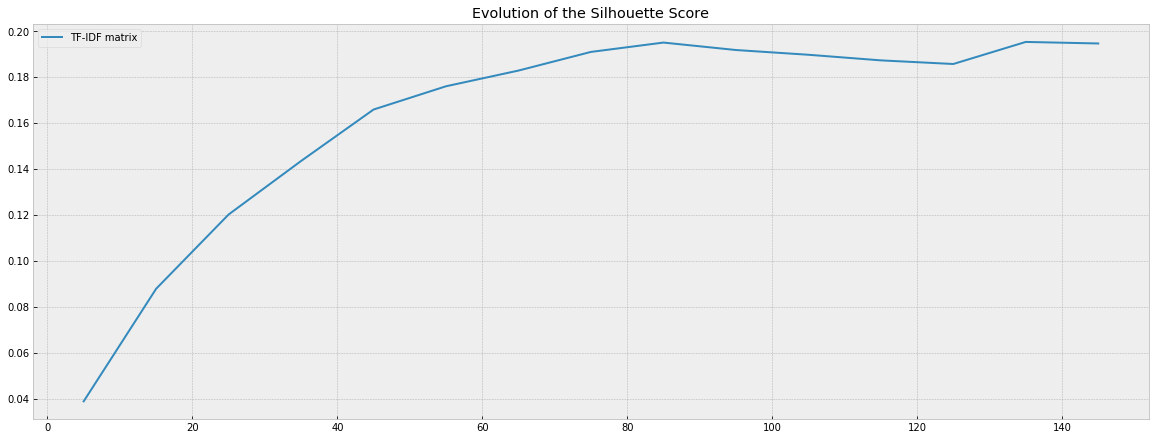

In [97]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

The highest value for the silhouette score is when there are 135 clusters. So we'll chose this value.



Text(0.5, 1.0, 'ACP with 135 clusters')

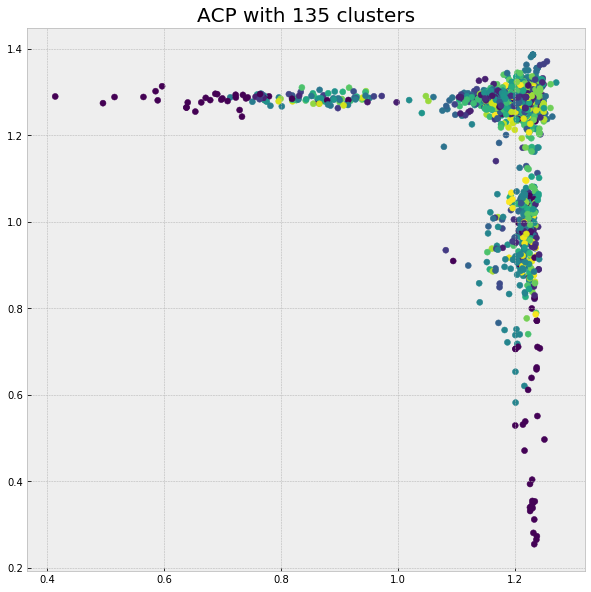

In [99]:
n_clusters = 135

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 135 clusters", fontsize="20")

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

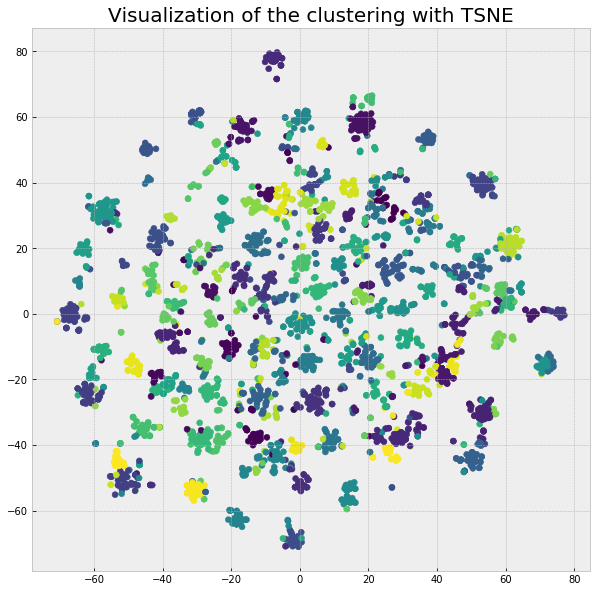

In [100]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")

In [101]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [102]:
with open('product_clusters.pickle', 'wb') as h:
    pickle.dump(dict_article_to_cluster, h)

Creating customer categories

Intermediate dataset grouped by invoices

In [103]:
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalPrice"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [104]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

Final dataset grouped by customers

In [106]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [107]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [108]:
df_grouped_final.head(5)

TotalPrice                   min_recency max_recency frequency  \
                  min    max       mean    <lambda>    <lambda>  <lambda>   
CustomerID                                                                  
12346             0.0    0.0   0.000000       325.0       325.0         1   
12347            13.2   45.0  23.308571         2.0       367.0         7   
12348            39.6  150.0  82.840000        75.0       358.0         4   
12349            15.0   15.0  15.000000        18.0        18.0         1   
12350            25.2   25.2  25.200000       310.0       310.0         1   

           monetary_value Quantity  Country  
                 <lambda>      sum <lambda>  
CustomerID                                   
12346                0.00    74215       35  
12347             4310.00     2458       16  
12348             1437.24     2332       12  
12349             1457.55      630       18  
12350              294.40      196       24

In [109]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [110]:
df_grouped_final.head(5)

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country
CustomerID,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24


In [111]:
df2_grouped_final.head(5)


,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
12347,0.015592,0.0,0.024501,0.093828,0.0,0.032854,0.004037,0.0,0.008770,0.002367,...,0.000000,0.0,0.0,0.0,0.0,0.009049,0.000000,0.003898,0.0,0.0
12348,0.000000,0.0,0.116056,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.027553,0.0,0.0
12349,0.015437,0.0,0.027196,0.000000,0.0,0.000000,0.000000,0.0,0.023876,0.000000,...,0.013914,0.0,0.0,0.0,0.0,0.000000,0.008576,0.000000,0.0,0.0
12350,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.230299,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


Clustering customers

In [112]:
X1 = df_grouped_final.as_matrix()
X2 = df2_grouped_final.as_matrix()

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [113]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.8700981040257759 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.8811864073298342 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.2542374210752103 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.3407208078961857 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.38903653652986553 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.3986814522318974 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.4069232343846085 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.4105887561860805 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.4078202235229066 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.4089478595312135 with Std Scaling


We want to have at least 5, 6 clusters so we won't take 2 or 3 clusters even though they have the highest silhouette scores, 8 clusters would fit the best here.

In [114]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

In [115]:
df_grouped_final["cluster"] = clusters

In [116]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35,2,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,4,...,0.000000,0.0,0.0,0.0,0.0,0.009049,0.000000,0.003898,0.0,0.0
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12,4,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.027553,0.0,0.0
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18,4,...,0.013914,0.0,0.0,0.0,0.0,0.000000,0.008576,0.000000,0.0,0.0
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24,6,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [117]:
final_dataset_V2 = final_dataset.reset_index()

In [118]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [119]:
with open('df_cleaned.pickle', 'wb') as f:
    pickle.dump(df_cleaned, f)

Interpreting the clusters

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

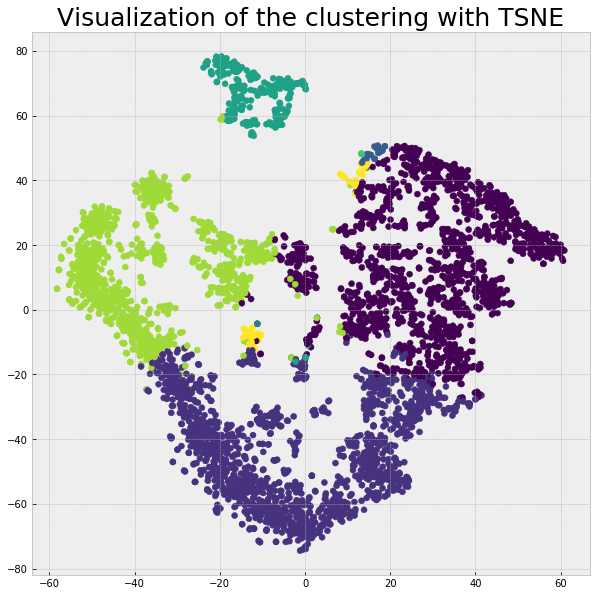

In [122]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

Graphically the clusters are distinctive enough. Let's take a closer look at the clusters that contain few customers.

Cluster 0

In [123]:
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12352,0.00,35.70,16.842857,36.0,296.0,7,1265.41,526,24,0,...,0.015805,0.000000,0.000000,0.000000,0.000000,0.009246,0.000000,0.049944,0.000000,0.000000
12356,25.50,102.00,51.300000,22.0,325.0,3,2487.43,1573,26,0,...,0.000000,0.000000,0.000000,0.006834,0.000000,0.000000,0.000000,0.005307,0.000000,0.000000
12363,15.90,69.36,42.630000,109.0,242.0,2,552.00,408,36,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12409,0.00,79.20,47.200000,78.0,182.0,3,11056.93,5551,32,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.005644,0.029249,0.029737,0.000000,0.000000
12421,9.90,30.00,18.225000,15.0,319.0,4,639.04,478,30,0,...,0.000000,0.000000,0.038730,0.000000,0.051640,0.000000,0.027698,0.000000,0.000000,0.015774
12433,10.08,60.00,28.422857,0.0,373.0,7,13375.87,11071,24,0,...,0.000000,0.000000,0.000000,0.000000,0.002243,0.000000,0.000000,0.009303,0.000000,0.000754
12451,9.12,15.00,12.324000,10.0,324.0,5,8893.52,6574,32,0,...,0.003198,0.000000,0.004453,0.000000,0.002193,0.000000,0.000000,0.006173,0.000000,0.011321
12456,15.00,28.08,19.660000,44.0,254.0,3,2553.89,1618,32,0,...,0.009867,0.000000,0.000000,0.000000,0.005776,0.004581,0.000000,0.000000,0.000000,0.000000
12457,0.00,196.35,69.608333,66.0,239.0,6,1612.23,836,32,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120795,0.000000,0.006252


In [124]:
final_dataset[final_dataset['cluster']==0].mean()

min                 10.373488
max                 71.196802
mean                31.186975
min_recency         36.564797
max_recency        312.156673
frequency            6.985816
monetary_value    2635.489813
quantity          1551.911670
country             34.858801
cluster              0.000000
Cluster_0            0.012788
Cluster_1            0.008508
Cluster_2            0.010429
Cluster_3            0.010024
Cluster_4            0.001370
Cluster_5            0.010155
Cluster_6            0.022107
Cluster_7            0.010592
Cluster_8            0.029551
Cluster_9            0.006744
Cluster_10           0.002408
Cluster_11           0.010208
Cluster_12           0.012441
Cluster_13           0.003194
Cluster_14           0.020069
Cluster_15           0.006900
Cluster_16           0.002987
Cluster_17           0.007330
Cluster_18           0.004483
Cluster_19           0.011796
                     ...     
Cluster_105          0.003292
Cluster_106          0.007475
Cluster_10

In [125]:
temp_final_df = final_dataset.reset_index()

In [126]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['CustomerID'])

In [127]:
cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              10.268091
UnitPrice              2.899498
QuantityCanceled       0.128702
TotalPrice            17.437493
frequency             11.192367
min_recency           24.465389
monetary_value      5547.580530
dtype: float64

In [128]:
cluster0['Description'].value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    1349
JUMBO BAG RED RETROSPOT               1089
REGENCY CAKESTAND 3 TIER               977
PARTY BUNTING                          932
ASSORTED COLOUR BIRD ORNAMENT          928
LUNCH BAG RED RETROSPOT                902
LUNCH BAG  BLACK SKULL.                754
SET OF 3 CAKE TINS PANTRY DESIGN       729
LUNCH BAG CARS BLUE                    679
LUNCH BAG PINK POLKADOT                678
Name: Description, dtype: int64

In [129]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [130]:
cluster0_grouped['RFMScore'].value_counts()

111    363
211    156
322    122
222    118
122     97
321     81
221     67
311     60
121     48
112     47
323     44
223     42
212     42
333     39
332     37
233     31
312     22
123     21
133     20
334     18
232     18
234     15
132      7
134      6
231      5
324      4
113      3
224      3
412      2
331      2
213      2
411      2
124      2
433      1
313      1
424      1
114      1
422      1
Name: RFMScore, dtype: int64

In [131]:
cluster0_grouped['Country'].value_counts()

35    1515
30      13
32       7
26       6
31       2
25       2
24       2
23       2
36       1
29       1
Name: Country, dtype: int64

These customers seems to be good for datazone since they have good RFM scores, the 4 most represented categories are (111, 211, 322, 222). They seem to be normal customers.



Key figures:

Min Basket Price: 10.86
Mean Basket Price: 30.60
Max Basket Price: 68.57

Quantity: 10.00

UnitPrice: 2.87
QuantityCanceled: 0.04
TotalPrice: 17.09
Frequency 11.134050
Recency 24.574626
TOP 10 bought products :

WHITE HANGING HEART T-LIGHT HOLDER: 1345
JUMBO BAG RED RETROSPOT: 1079
REGENCY CAKESTAND 3 TIER: 960
ASSORTED COLOUR BIRD ORNAMENT: 926
PARTY BUNTING: 924
LUNCH BAG RED RETROSPOT: 898
LUNCH BAG BLACK SKULL: 753
SET OF 3 CAKE TINS PANTRY DESIGN: 725
LUNCH BAG CARS BLUE: 679
LUNCH BAG PINK POLKADOT: 676


Cluster 1

I already have done all the same analysis for the other clusters, so I won't put all of the code here but the idea is the same

This cluster represents almost lost customers. The weird part about them is that there are some months when they didn't shop at all, it looks like a pattern.

Key figures:

Min Basket Price: 20.83
Mean Basket Price: 33.77
Max Basket Price: 26.43

Quantity: 9.06

UnitPrice: 2.68
QuantityCanceled: 0.02
TotalPrice: 13.77
Frequency 3.065758
Recency 36.131902
TOP 10 bought products :

PAPER CHAIN KIT 50'S CHRISTMAS: 267
BAKING SET 9 PIECE RETROSPOT: 263
WHITE HANGING HEART T-LIGHT HOLDER: 250
ASSORTED COLOUR BIRD ORNAMENT: 247
REX CASH+CARRY JUMBO SHOPPER: 223
HOT WATER BOTTLE KEEP CALM: 215
REGENCY CAKESTAND 3 TIER: 208
RABBIT NIGHT LIGHT: 200
GARDENERS KNEELING PAD KEEP CALM: 194
SPOTTY BUNTING: 193

Let's quickly classify the clusters in terms of importance to Datazon :

Cluster 2: high frequency with a lot of quantity (mean basket price of 513) bought on average and high monetary value (VIP clients)
Cluster 7 : very high purchase frequency with a mean basket price of 150 but good monetary value.
Cluster 4: very high basket price (huge quantity of products bought on average)
Cluster 0: good average customers
Cluster 6: good foreign customers
Cluster 1: almost lost customers
Cluster 5: highest monetary value but only one or two purchases over the year
Cluster 3: lost customers